In [3]:
##Import necessary packages
import os
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor

#Import written functions for this analysis
import sys
sys.path.insert(0, '../code/python')
from price_update import price_update
from reset_algo import reset_algo
from state_dependent_accuracy import state_dependent_accuracy

#Read in household appliance data
working_dir = os.getcwd()
cat531 = pd.read_csv(os.path.join(working_dir,"..","data/expanded/cat531_small.csv"))
#Fill in missing inverse sqrt duration
cat531.fillna(value = 0, inplace = True)

#Preliminaries - model definition (linear vs. KNN) and required predictor variables
model_lin = linear_model.LinearRegression()
model_ml = KNeighborsRegressor(n_neighbors=3)

pred_cols_lin =  ['sqrt_duration', 'inv_sqrt_duration', 'chg_p',\
                 'd0', 'd1', 'd2', 'd3', 'd4','d5','d6','d7','d8','d9',\
                  'd10','d11','d12','d13','d14','d15','d16', \
                'd17','d18','d19','d20','d21','d22','d23']

pred_cols_lin2 =  ['sqrt_duration', 'inv_sqrt_duration', 'chg_p',\
                 'd0', 'd1', 'd2', 'd3', 'd4','d5','d6','d7','d8','d9',\
                 'd10','d11','d12','d13','d14','d15','d16', \
                 'd17','d18','d19','d20','d21','d22','d23', 'chg_rs']

ml_kmeans = ['lp_na', 'dlprcs_a_lst', 'sqrt_duration']

#Total dates in dataset
dates = cat531.sort_values(by='date').date.unique()

#Flag for robustness check
# 0 = no robustness check 
# 1 = addition of omitted macro vars to linear model
# 2 = addition of omitted idosynractic vars to linear model
# 3 = KNN vars for both
robust = 0

In [4]:
#Components to make a reset price dataframe
#rest_algo reads in a dataframe and lists of linear/machine learning predictors
#Items with price change are used as a training set
#Outputs predicted price change values for items without a price change

train_mat = np.empty([0,4])
test_mat = np.empty([0,3])
pred_vec_ml = np.empty([0,1])
pred_vec_lin = np.empty([0,1])
date_vec_test = np.empty([0,1])
date_vec_train = np.empty([0,1])
placeholder_vec_train = np.empty([0,1])

for i in range(1,len(dates)):
    if robust == 0:
        #Linear model vs. KNN
        y_pred_ml, y_pred_lin, date_train, date_test, test_data, train_data = \
        reset_algo(cat531[cat531.date == dates[i]], pred_cols_lin, ml_kmeans, model_lin, model_ml)
    
    if robust == 1:
         #Linear model + Macro vs. KNN
        y_pred_ml, y_pred_lin, date_train, date_test, test_data, train_data = \
        reset_algo(cat531[cat531.date == dates[i]], pred_cols_lin2, ml_kmeans, model_lin, model_ml)
        
    if robust == 2:
        #All vars
        y_pred_ml, y_pred_lin, date_train, date_test, test_data, train_data = \
        reset_algo(cat531[cat531.date == dates[i]], pred_cols_lin2 + ml_kmeans, ml_kmeans, model_lin, model_ml)
            
    if robust == 3:
        #KNN for both
        y_pred_ml, y_pred_lin, date_train, date_test, test_data, train_data = \
        reset_algo(cat531[cat531.date == dates[i]],  ml_kmeans, ml_kmeans, model_lin, model_ml)
    
    train_mat = np.concatenate((train_mat,train_data.as_matrix()), axis=0)
    test_mat = np.concatenate((test_mat,test_data.as_matrix()), axis=0)
    pred_vec_ml = np.concatenate((pred_vec_ml,y_pred_ml.reshape((len(y_pred_ml),1))), axis = 0)
    pred_vec_lin = np.concatenate((pred_vec_lin,y_pred_lin.reshape((len(y_pred_lin),1))), axis = 0)
    date_vec_train = np.concatenate((date_vec_train, date_train.reshape((len(date_train),1))), axis = 0)
    date_vec_test = np.concatenate((date_vec_test, date_test.reshape((len(date_test),1))), axis = 0)
    placeholder_vec_train = np.concatenate((placeholder_vec_train,np.zeros((1,len(train_data))).reshape((len(train_data)),1)), axis = 0)

#Linear model dataframe (i.e., mean change)    
d1 = {'id': train_mat[:,0], 'chg': train_mat[:,1], 'lp_na': train_mat[:,2], 'dlprcs_a': train_mat[:,3], 'date': date_vec_train.reshape((len(date_vec_train))), 'mean_chg': placeholder_vec_train.reshape((len(placeholder_vec_train))) }
#Machine learning dataframe   
d2 = {'id': test_mat[:,0], 'chg': test_mat[:,1], 'lp_na': test_mat[:,2], 'dlprcs_a': pred_vec_ml.reshape((len(pred_vec_ml))), 'date': date_vec_test.reshape((len(date_vec_test))), 'mean_chg': pred_vec_lin.reshape((len(pred_vec_lin)))}
reset_cal_df = pd.DataFrame(d1).append(pd.DataFrame(d2), ignore_index = True)

In [5]:
uni_ids = reset_cal_df.id.unique()
accuracy_mat = np.empty([1,8])

#price_update function - For each unique product ID, update prices 
#with its estimated price change during months 
#without a price change, and to its actual price change when a change occurs

#state_depedent_accuracy - Function that assess periods where a price change 
#occured and there was NOT a price change in the period prior
#it counts the number of times the period before the price change estimated 
#the correct direction, as well as the deviation of the 
#predicted price from the actual price


for id in range(0,len(uni_ids)):
    id_df = price_update(reset_cal_df[reset_cal_df.id == uni_ids[id]].sort_values(by='date'), \
                                    reset_cal_df[reset_cal_df.id == uni_ids[id]].sort_values(by='date').lp_na.shift(-1), \
                                    reset_cal_df[reset_cal_df.id == uni_ids[id]].sort_values(by='date').date.unique())
    
    accuracy_vec = state_dependent_accuracy(id_df.chg,(id_df.chg.shift(1)+id_df.chg), \
                                            id_df.reset_ml.shift(1), id_df.reset_mean.shift(1), \
                                            id_df.act_price.shift(1), id_df.act_price)
    
    accuracy_mat = np.concatenate((accuracy_mat,accuracy_vec.reshape((1,len(accuracy_vec)))), axis=0)

reset_df_final = pd.DataFrame(accuracy_mat[1:,:], columns=['ml_acc_dec', 'avg_mag_ml_dec', 'ml_acc_inc', \
                                                           'avg_mag_ml_inc', 'mean_acc_dec', 'avg_mag_mean_dec', \
                                                           'mean_acc_inc', 'avg_mag_mean_inc']).astype(object)
reset_df_final['id'] = uni_ids

#Print results
print("KNN: Precition Accuracy Measures")
print("--------------------------------")
print("Average Price Decrease Accuracy: " + str(round(reset_df_final.ml_acc_dec.mean(),3)*100) + "%")
print("Deviation Before Price Decrease: " + str(round(reset_df_final.avg_mag_ml_dec.mean(),3)*100) + "%")
print("Average Price Increase Accuracy: " + str(round(reset_df_final.ml_acc_inc.mean(),3)*100) + "%")
print("Deviation Before Price Increase: " + str(round(reset_df_final.avg_mag_ml_inc.mean(),3)*100) + "%")
print("")
print("Linear: Precition Accuracy Measures")
print("-----------------------------------")
print("Average Price Decrease Accuracy: " + str(round(reset_df_final.mean_acc_dec.mean(),3)*100) + "%")
print("Deviation Before Price Decrease: " + str(round(reset_df_final.avg_mag_mean_dec.mean(),3)*100) + "%")
print("Average Price Increase Accuracy: " + str(round(reset_df_final.mean_acc_inc.mean(),3)*100) + "%")
print("Deviation Before Price Increase: " + str(round(reset_df_final.avg_mag_mean_inc.mean(),3)*100) + "%")

KNN: Precition Accuracy Measures
--------------------------------
Average Price Decrease Accuracy: 73.4%
Deviation Before Price Decrease: -31.6%
Average Price Increase Accuracy: 72.5%
Deviation Before Price Increase: 14.4%

Linear: Precition Accuracy Measures
-----------------------------------
Average Price Decrease Accuracy: 71.1%
Deviation Before Price Decrease: -24.3%
Average Price Increase Accuracy: 24.2%
Deviation Before Price Increase: 10.7%


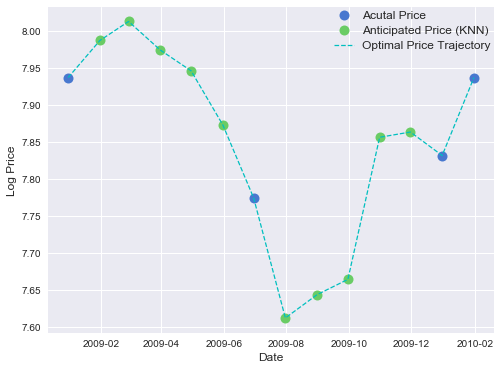

In [4]:
#Evaluate trajectory for product 56316
import matplotlib.pyplot as plt
%matplotlib inline

#Format
import seaborn as sns
sns.set(style="darkgrid")
sns.set_palette("muted")

id_df_56316 = price_update(reset_cal_df[reset_cal_df.id == 56316].sort_values(by='date'), \
                                    reset_cal_df[reset_cal_df.id == 56316].sort_values(by='date').lp_na.shift(-1), \
                                    reset_cal_df[reset_cal_df.id == 56316].sort_values(by='date').date.unique())

id_df_56316 = id_df_56316.iloc[1:15,:]


plt.figure(figsize=(8, 6))
plt.plot_date(x=id_df_56316[id_df_56316.chg == 1].date, y = id_df_56316[id_df_56316.chg == 1].reset_ml, label='Acutal Price', markersize = 10)
plt.plot_date(x=id_df_56316[id_df_56316.chg == 0].date, y = id_df_56316[id_df_56316.chg == 0].reset_ml, label='Anticipated Price (KNN)', markersize = 10)
plt.plot_date(x=id_df_56316.date, y = id_df_56316.reset_ml, fmt= 'c--', linewidth=1.25, label='Optimal Price Trajectory')
plt.legend(loc=0, borderaxespad=0.)
ltext = plt.gca().get_legend().get_texts()
plt.setp(ltext[0], fontsize=12)
plt.setp(ltext[1], fontsize=12)
plt.setp(ltext[2], fontsize=12)
plt.xlabel('Date', size=12)
plt.ylabel('Log Price', size=12)
plt.show()

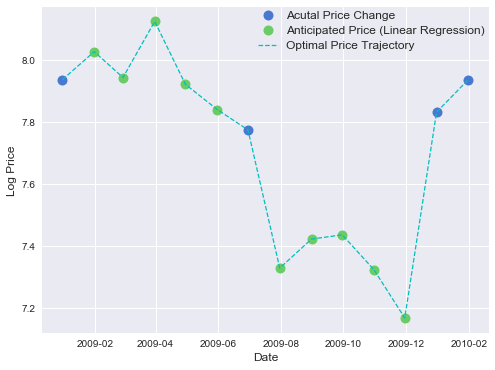

In [5]:
plt.figure(figsize=(8, 6))
plt.plot_date(x=id_df_56316[id_df_56316.chg == 1].date, y = id_df_56316[id_df_56316.chg == 1].reset_mean, label='Acutal Price Change', markersize = 10)
plt.plot_date(x=id_df_56316[id_df_56316.chg == 0].date, y = id_df_56316[id_df_56316.chg == 0].reset_mean, label='Anticipated Price (Linear Regression)', markersize = 10 )
plt.plot_date(x=id_df_56316.date, y = id_df_56316.reset_mean, fmt= 'c--', linewidth=1.25, label='Optimal Price Trajectory')
plt.legend(loc=0, borderaxespad=0.)
ltext = plt.gca().get_legend().get_texts()
plt.setp(ltext[0], fontsize=12)
plt.setp(ltext[1], fontsize=12)
plt.setp(ltext[2], fontsize=12)
plt.xlabel('Date', size=12)
plt.ylabel('Log Price', size=12)
plt.show()